In [1]:
import PIL.Image
import numpy as np
from typing import Union
from glob import glob
import pandas as pd
import os
from treys import Card
from termcolor import colored
from utils import eval_listof_games , debug_listof_games, save_results , load_results

In [2]:
import skimage.io
import matplotlib.pyplot as plt
#libraries for exercise 1.2 Region growing
from skimage.segmentation import flood, flood_fill
from skimage import morphology
from skimage.morphology import closing, opening, disk, square
import numpy as np

#libraries for exercise 1.3 Contour detection
from skimage import filters
import scipy
import cv2 as cv

### Strategie


Use setup data to isolate numbers/letters and symbols and define the selection features (Fourier might be good, as there is only 1 way to write 1 symbol so quite deterministic, and invariability to rotation).

Proceed by "player space"

- cards
    - we must go for the numbers/letters and signs just under, as cards hidden behind others cannot be classified using the whole card.
    - once we have all the contours"
        - quick control of the possibility that a card is hidden (high fourier frequency ?) or a "dressed/ace" ? The come back with less frequencies ?
        - find the contours of interest by looking for which contour are the closest to target contours (experiment a bit with set up cards)?
    
- chips
    - Separate everything given the color (red, black, blue, green, white). 
    - get them when we get the rest

Import all train data

In [3]:
path_data = 'data/train'
i = 0
file = os.path.join(path_data, f"train_{str(i).zfill(2)}.jpg")
images = []

while os.path.exists(file):
    im = skimage.io.imread(file)
    images.append(im)
    i += 1
    file = os.path.join(path_data, f"train_{str(i).zfill(2)}.jpg")

Subsample to 2 images for now

In [4]:
images = [images[0], images[22]]

## Plot RGB channels

In [5]:
print(np.min([images[0]]), np.max(images[0]))

0 255


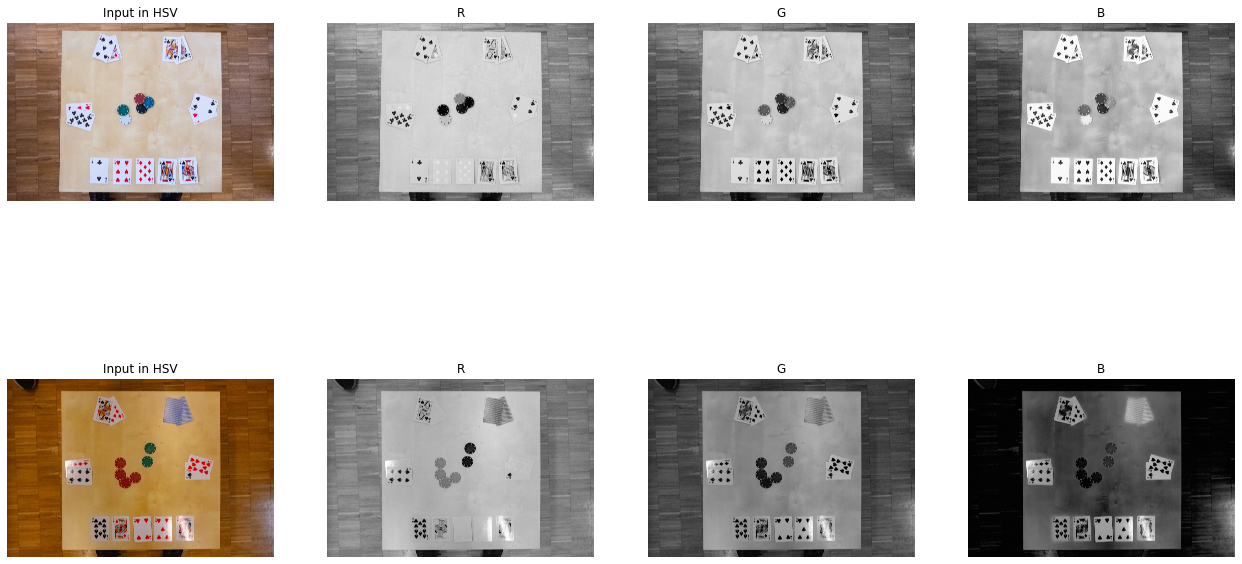

In [6]:
fig, ax = plt.subplots(ncols=4, nrows=2, figsize=(22, 12))

for i in range(2):
    ax[i,0].imshow(images[i])
    ax[i,0].set_title('Input in HSV')
    ax[i,0].axis('off')
    
    ax[i,1].imshow(images[i][:,:,0], cmap = 'gray')
    ax[i,1].set_title('R')
    ax[i,1].axis('off')
    
    ax[i,2].imshow(images[i][:,:,1], cmap = 'gray')
    ax[i,2].set_title('G')
    ax[i,2].axis('off')
    
    ax[i,3].imshow(images[i][:,:,2], cmap = 'gray')
    ax[i,3].set_title('B')
    ax[i,3].axis('off')
    ascii

## Plot hsv channels

In [7]:
images_hsv = [skimage.color.rgb2hsv(images[0]), skimage.color.rgb2hsv(images[1])]

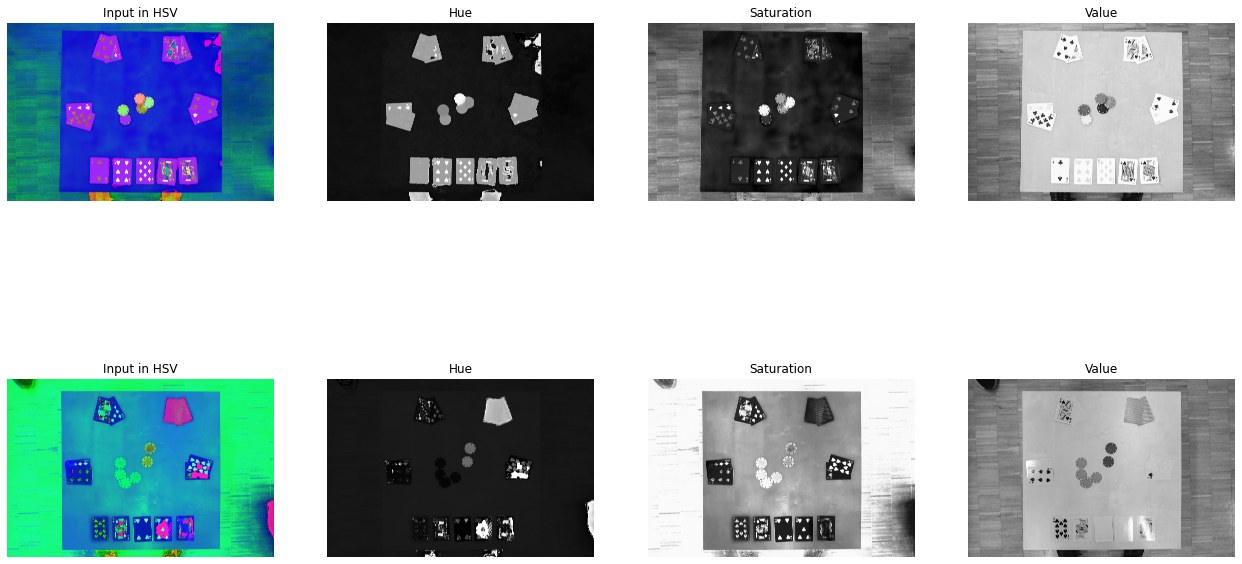

In [8]:
fig, ax = plt.subplots(ncols=4, nrows=2, figsize=(22, 12))

for i in range(2):
    ax[i,0].imshow(images_hsv[i])
    ax[i,0].set_title('Input in HSV')
    ax[i,0].axis('off')
    
    ax[i,1].imshow(images_hsv[i][:,:,0], cmap = 'gray')
    ax[i,1].set_title('Hue')
    ax[i,1].axis('off')
    
    ax[i,2].imshow(images_hsv[i][:,:,1], cmap = 'gray')
    ax[i,2].set_title('Saturation')
    ax[i,2].axis('off')
    
    ax[i,3].imshow(images_hsv[i][:,:,2], cmap = 'gray')
    ax[i,3].set_title('Value')
    ax[i,3].axis('off')
    ascii

In [ ]:
fig, axs = plt.subplots(ncols=3, nrows = 2, figsize=(15, 10))
titles = ['H', 'S', 'V']
colors = ['orange', 'gray', 'black']
for i in range(2):
    for j in range(3):
        hist = cv.calcHist([images_hsv[i]], channels=[j], mask=None, histSize=[256], ranges=[0, 256])
        axs[i,j].bar(np.arange(hist.shape[0]), hist.reshape(-1),  width=1, color = colors[i])
        
fig.suptitle('Histogram of RGB channels for each image')
plt.show()

## Isolation trials (sobel, ...)

Use smoothed Hue and threshold original image

In [33]:
def Hue_threshold():
    fig, axes = plt.subplots(ncols = 2, nrows = 2, figsize=(14,10))
    for ax, image, image_hsv in zip(axes, images, images_hsv):
        hue = image_hsv[:,:,0]
        hue = filters.gaussian(hue, sigma = 5)
        hue_background = hue[0,0]
        #tol = 0.2
        tol = np.std(hue)/4
        #print(np.mean(hue), np.std(hue))
        
        cond = (np.abs(hue - hue_background) < tol)
        output = np.copy(image)
        output[cond,:] = 0
        
        ax[0].imshow(image)
        ax[0].set_title('original')
        ax[1].imshow(output)
        ax[1].set_title('hue-thresholded')

    plt.show()

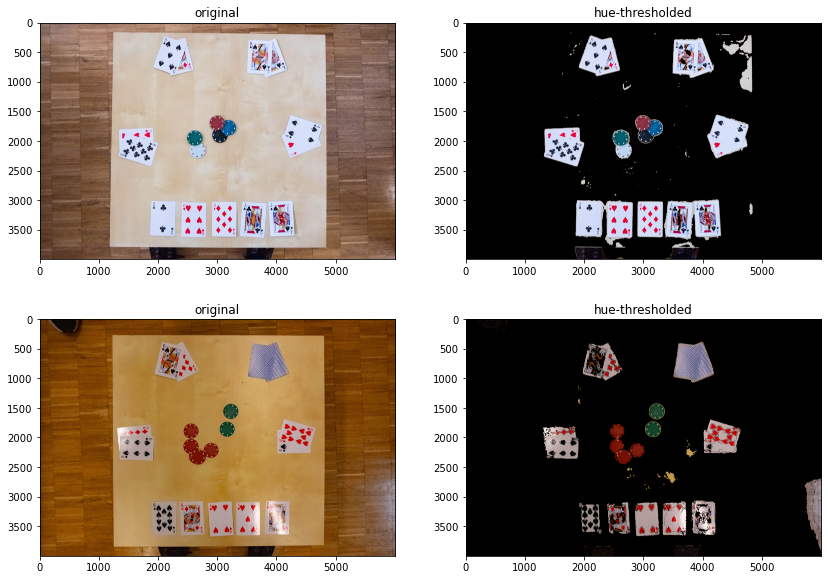

In [34]:
Hue_threshold()

Simple sobel

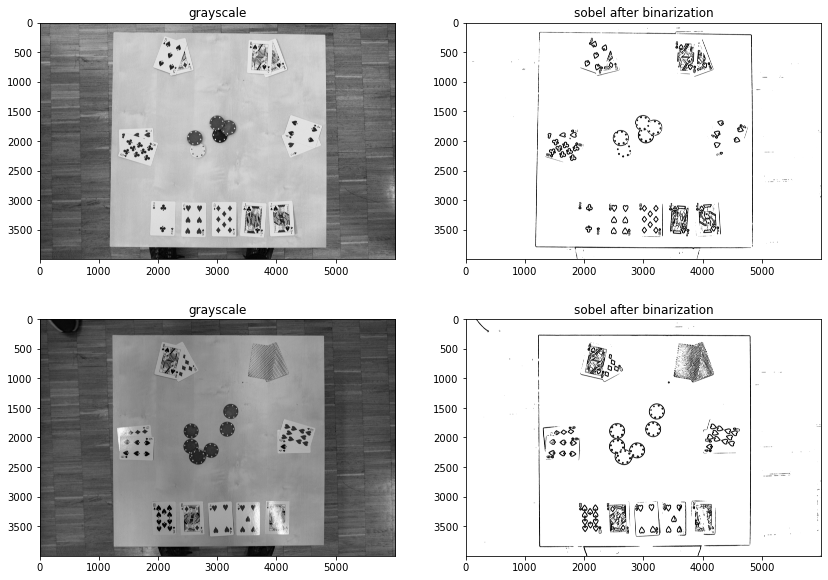

In [44]:
fig, axes = plt.subplots(ncols = 2, nrows = 2, figsize=(14,10))
for ax, image in zip(axes, images):
    # sobel
    grayscale = skimage.color.rgb2gray(image)
    
    ax[0].imshow(grayscale, cmap = plt.cm.gray)
    ax[0].set_title('grayscale')
    
    smoothed = filters.gaussian(grayscale, sigma = 5)
    sob = filters.sobel(smoothed)
    
    otsu = filters.threshold_otsu(sob)
    output = sob < otsu

    ax[1].imshow(output, cmap=plt.cm.gray)
    ax[1].set_title('sobel after binarization')

plt.show()

Text(0.5, 1.0, 'sobel after binarization')

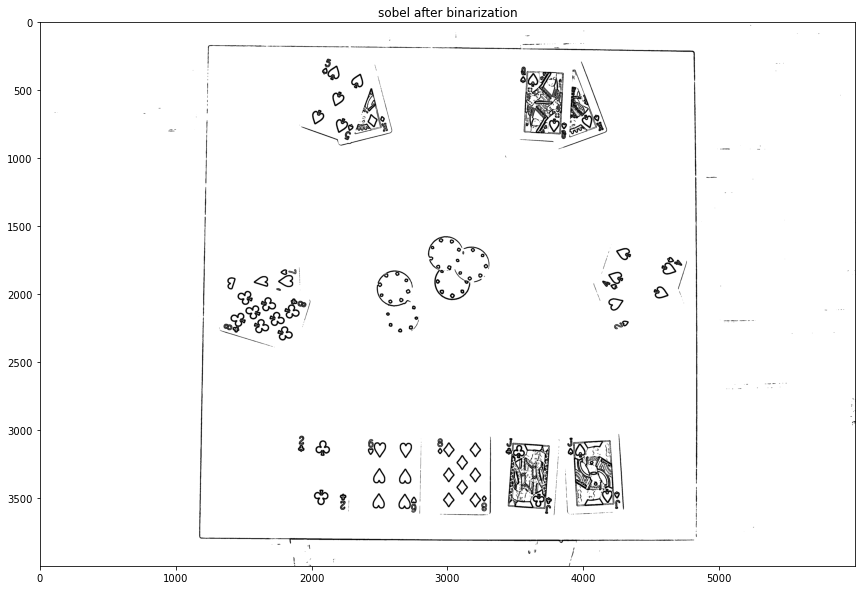

In [40]:
image = images[0]
grayscale = skimage.color.rgb2gray(image)
smoothed = filters.gaussian(grayscale, sigma = 3)
sob = filters.sobel(smoothed)

otsu = filters.threshold_otsu(sob)
output = sob < otsu

plt.figure(figsize=(15,10))
plt.imshow(output, cmap=plt.cm.gray)
plt.title('sobel after binarization')
plt.shpw()

Sobel trials on Hue

In [32]:
#from skimage.morphology import closing, opening, disk, square

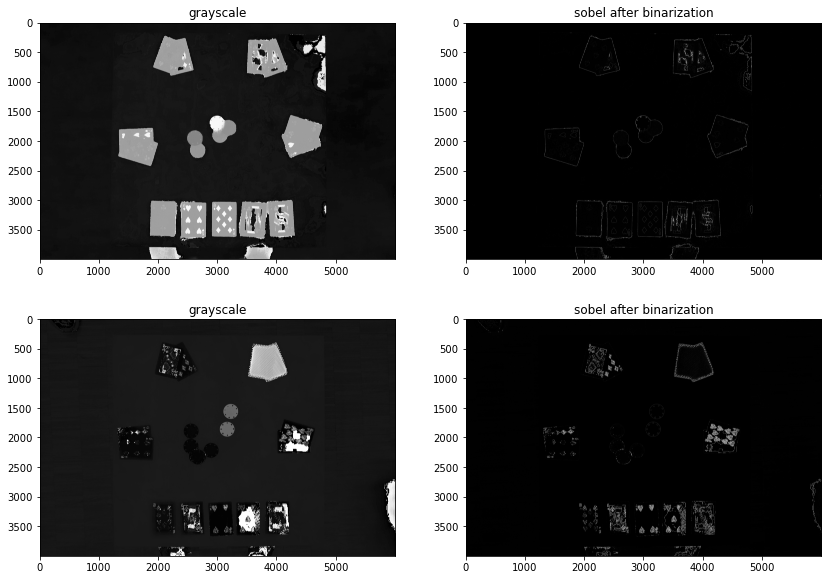

In [35]:

fig, axes = plt.subplots(ncols = 2, nrows = 2, figsize=(14,10))
for i, (ax, hue) in enumerate(zip(axes, images_hsv)):
    ax[0].imshow(images_hsv[i][:,:,0], cmap = plt.cm.gray)
    ax[0].set_title('grayscale')
    
    # sobel
    sob = filters.sobel(images_hsv[i][:,:,0])
    otsu = filters.threshold_otsu(sob)
    output = sob < otsu
    output = sob
    
    ax[1].imshow(output, cmap=plt.cm.gray)
    ax[1].set_title('sobel after binarization')

plt.show()

Experimenting with grayscale histograms